In [4]:
#importing all the libraries need to implement the models
import pandas as pd #to reached the dataset in the form of dataframe
import numpy as np #to perform mathematical operations
import re
import string
from nltk.corpus import stopwords #this package containd list of stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
import keras
from keras.layers import Dense, LSTM, Embedding, Input
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer #importing the vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
import seaborn as sns

### Reading the training and testing data

In [5]:
comment_train = pd.read_csv("train.csv")

comment_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Data type of each fields

In [6]:
comment_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
comment_test = pd.read_csv("test.csv")
comment_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [8]:
df_toxic_category = comment_train.drop(['id', 'comment_text'], axis=1) #different labels of toxic
df_toxic_category

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


### Data visualisation and analysis


In [9]:
comment_train.describe() #it gives informations like mean,std, no of rows etc

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: ylabel='count'>

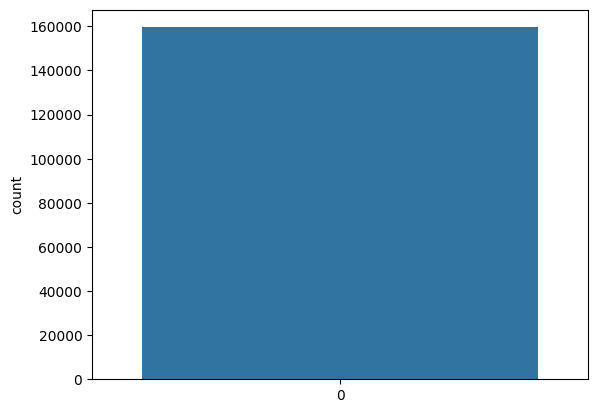

In [10]:
sns.countplot(df_toxic_category['toxic'])

<Axes: ylabel='count'>

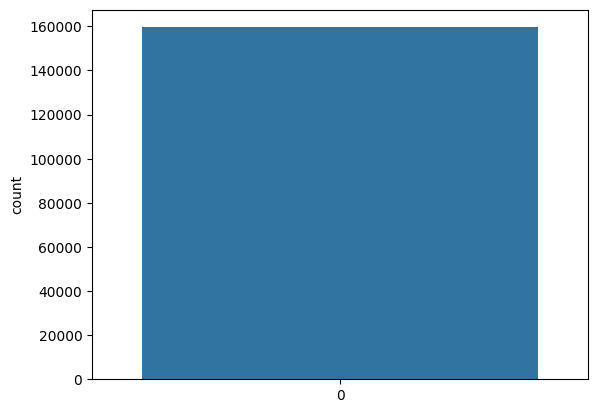

In [11]:
sns.countplot(df_toxic_category['severe_toxic'])

Axes(0.125,0.11;0.775x0.77)


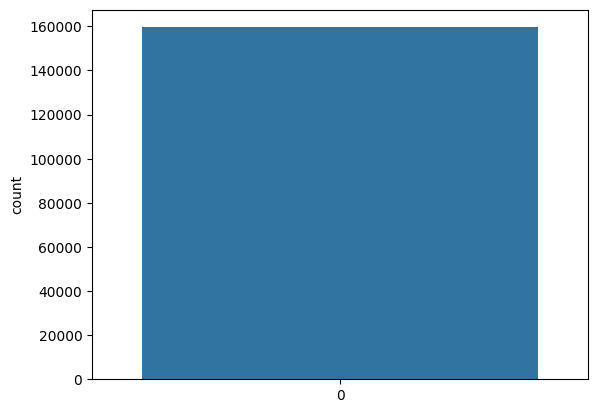

In [12]:
print(sns.countplot(df_toxic_category['obscene']))

Axes(0.125,0.11;0.775x0.77)


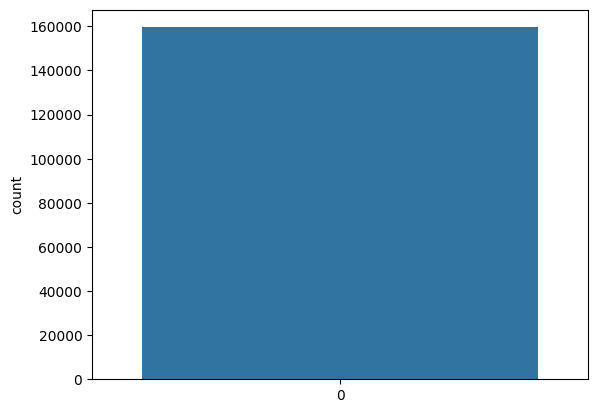

In [13]:
print(sns.countplot(df_toxic_category['threat']))

Axes(0.125,0.11;0.775x0.77)


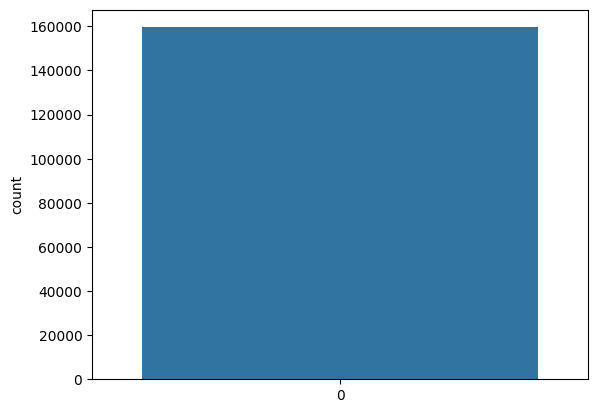

In [14]:
print(sns.countplot(df_toxic_category['insult']))

Axes(0.125,0.11;0.775x0.77)


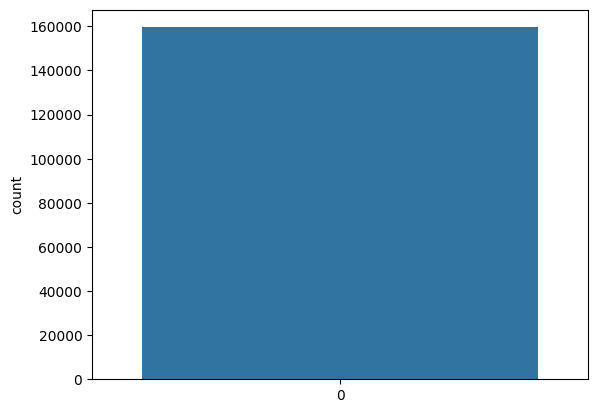

In [15]:
print(sns.countplot(df_toxic_category['identity_hate']))

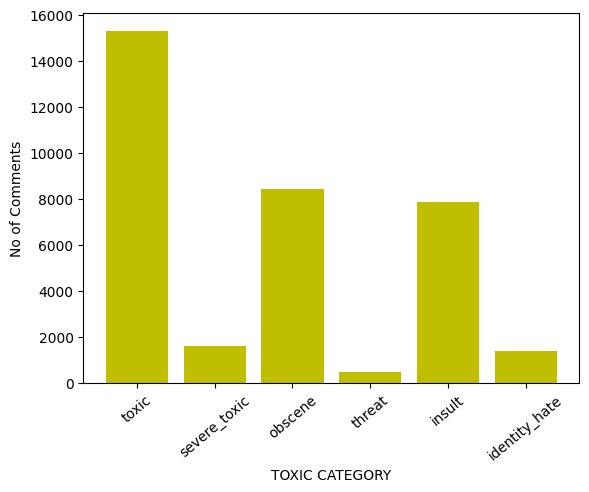

In [16]:
# generating the bar graph to compare the count of each labels
Toxic = df_toxic_category
ValueCounts = []
subdivisions  = list(Toxic.columns.values)
for f in subdivisions:
    ValueCounts.append((f, Toxic[f].sum()))
ValueCounts
lab=[] #empty list to store the labels of dataset
val=[] #empty list to store the count of the values
for i in ValueCounts:
    lab.append(i[0])
    val.append(i[1])

plt.bar(lab,val,color='y')
plt.xticks(rotation=40)
plt.xlabel("TOXIC CATEGORY")
plt.ylabel("No of Comments")
plt.show()

From the graph above we can clearly see that our dataset set is imbalanced. We need to make our dataset balanced so that our model does not overfit's the data. Firstly lets try and run the model without performing any balancing operations on the dataset.

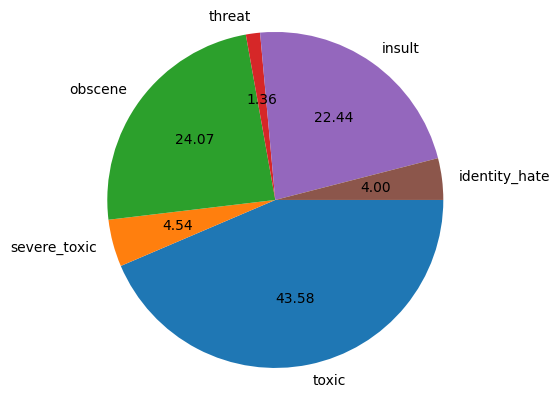

In [17]:
plt.pie(val,labels=lab,autopct='%.2f',counterclock=False)
plt.axis('equal')
plt.show()

In [18]:
cols=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

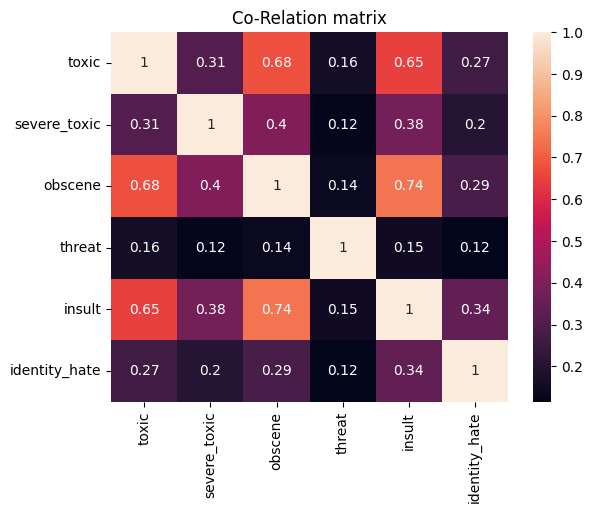

<Figure size 1200x500 with 0 Axes>

In [19]:
#defining co-relation matrix
data_category = df_toxic_category
co_relation_matrix = data_category.corr()
plt.title("Co-Relation matrix")
sns.heatmap(co_relation_matrix,annot=True) 
plt.figure(figsize=(12,5))
plt.show()

From the above matrix we can observe that obscene and insult both have similar kind of values they are highly related to each others.

C:\Users\sksad\AppData\Local\Temp\ipykernel_6112\200337709.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_train["comment_text"].apply(lambda x : len(x)))


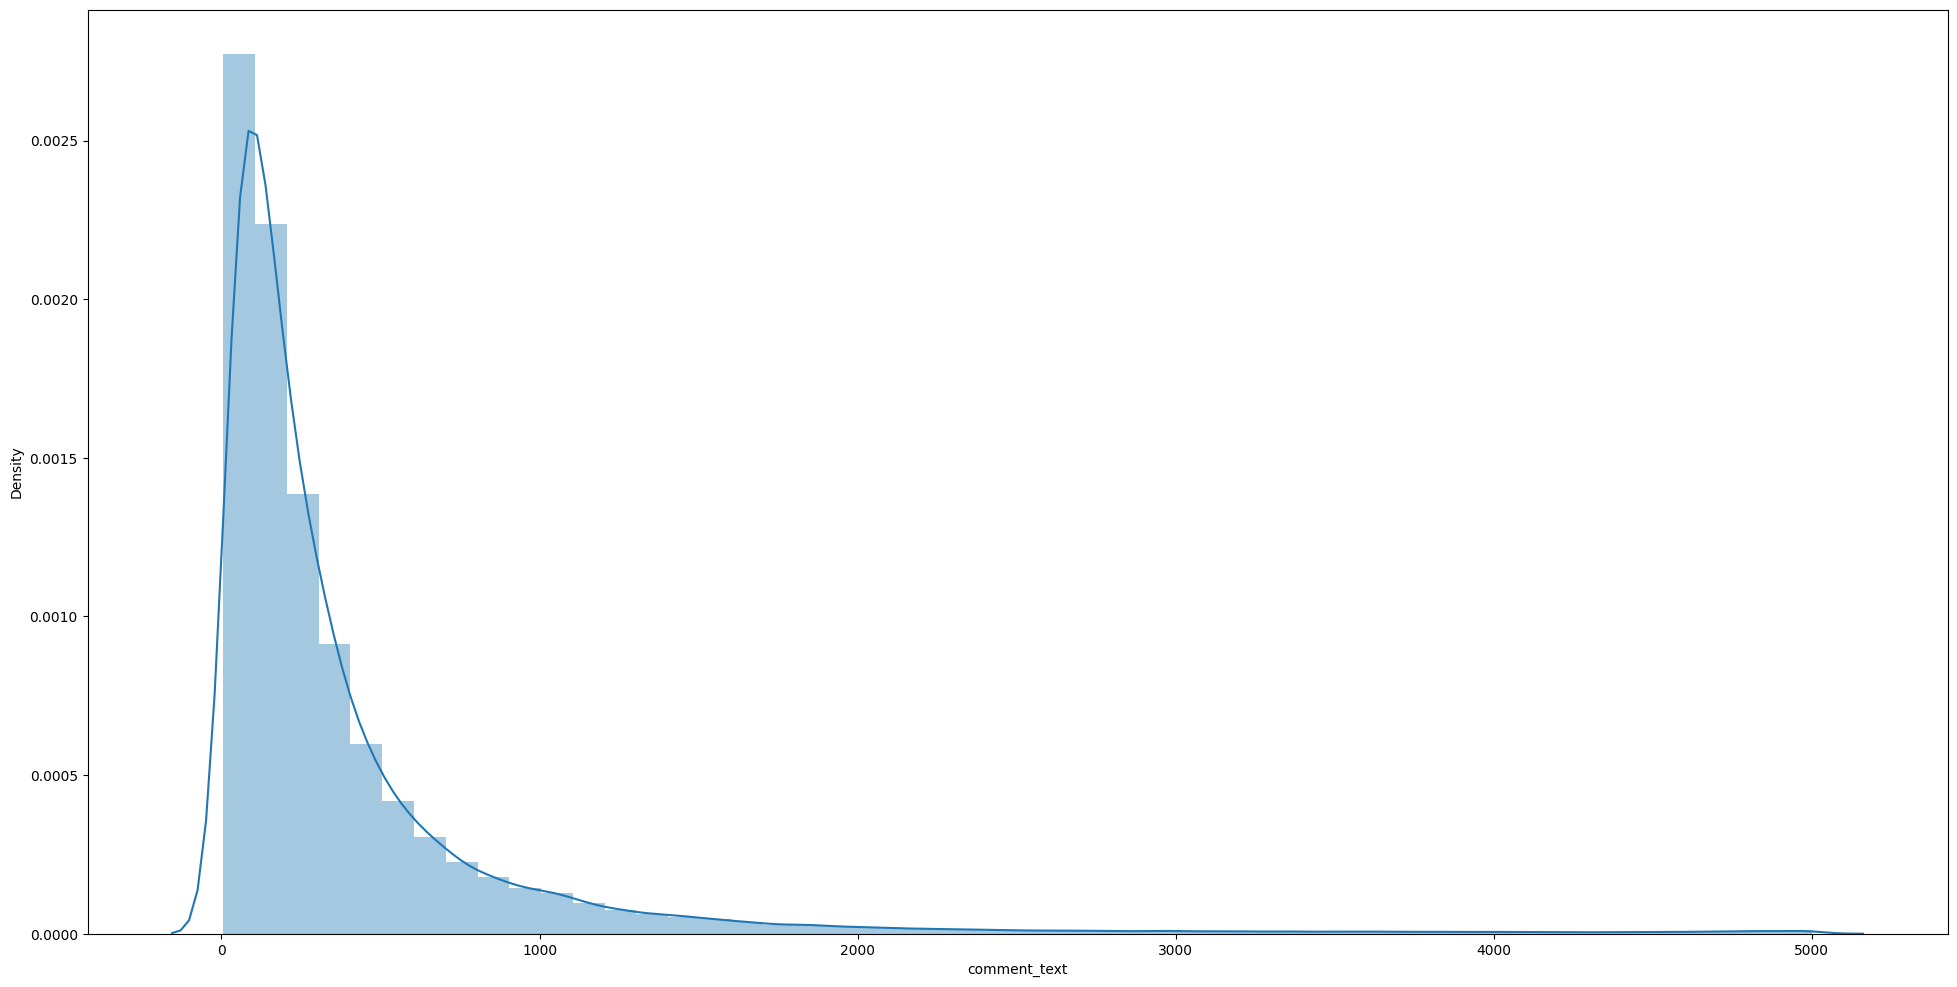

In [20]:
plt.figure(figsize = (24,12))
sns.distplot(comment_train["comment_text"].apply(lambda x : len(x)))
plt.show()

# Pre-processing the data

In [21]:

import nltk #importing nltk
nltk.download('stopwords') #downlaoding the stopwords
stop = stopwords.words('english') #As our training dataset is in only one language I am only importing the english stopwords 
puncutations = string.punctuation #From string package we can retrieve the list of puntuations using string.punctuation 
stop = stop + list(puncutations) #adding the list of puntautions on the array we created for stop words
stop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sksad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

# Removing annotation

In [22]:
def annotation(data_text):
    annotation_sentence = re.sub('[^a-z A-Z]+', ' ', data_text)
    return annotation_sentence

In [23]:
"""
Making the sentenses to lower case so that it can be passed in lemmetizing and stop words removal function
"""
def lower(data_text):
    lower_sentence = data_text.lower()
    return lower_sentence

# Lemmatiztion

Lemmatizing the words and joining them to return in the form of sentences not a words

In [24]:
def lem(data_text):
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(d, 'v') for d in data_text.split()] #tokkenizing the words
    lem_sentence=' '.join(lem_words)
    return lem_sentence

# Removing the stop words and puntuations

In [25]:
"""

from  string package list of punctuation can be extracted. After extracting the list of punctuation I have added it to the list 
of stop words so that after each and every iteration I have remove stop words and punctuation together.

"""
def stop_words_removal_puntuations(data_text):
    stop = list(set(stopwords.words('english')))
    puncutations = string.punctuation
    stop = stop + list(puncutations)
    stop_count=[d for d in data_text.split() if d not in stop]
    #print(stop_count)
    stop_count_sentence = ' '.join(stop_count)
    return stop_count_sentence

# Calling all the above funtion

In [26]:
"""
This function will call all the above function one by one for cleaning data.
"""
def preprocessing_text(sentence):
    processed_sentence = annotation(sentence)
    processed_sentence = lower(processed_sentence)
    processed_sentence = lem(processed_sentence)
    processed_sentence = stop_words_removal_puntuations(processed_sentence)
    
    return processed_sentence

In [27]:
def cleaning(data):
    text_data=preprocessing_text(data)
    return text_data

In [28]:
comment_train['Cleaned_data'] = comment_train['comment_text'].apply(cleaning)

In [29]:
comment_train[0:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Cleaned_data
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edit make username hardcore metall...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stick th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really try edit war guy constantly rem...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestions improvement wonder secti...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


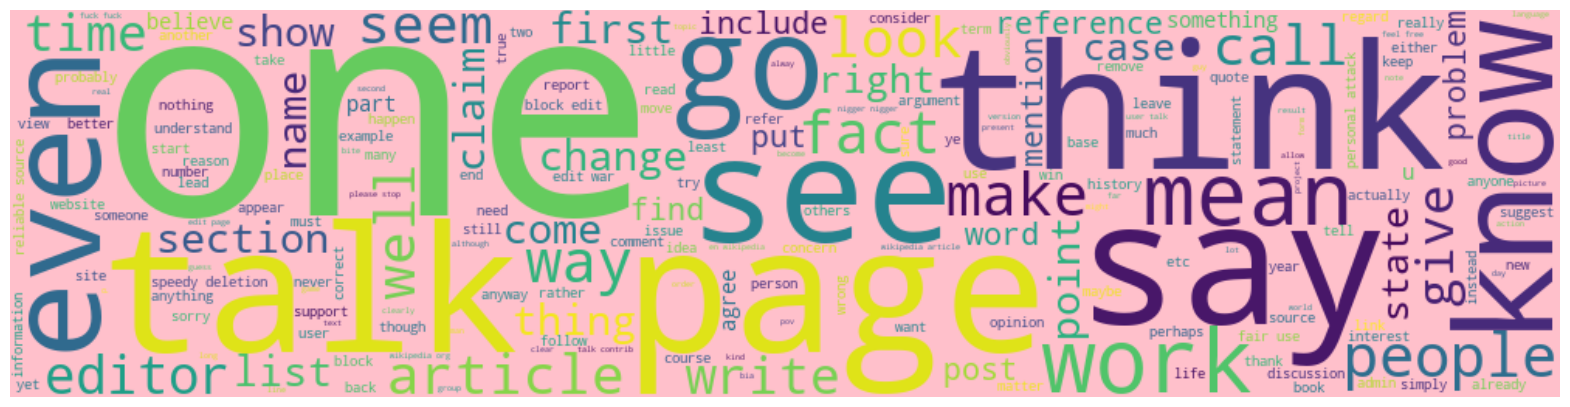

In [30]:
words = ' '.join([k for k in comment_train['Cleaned_data']])
W_C = WordCloud(width=1000, height=250, random_state=31, max_font_size=200,background_color='pink').generate(words)

plt.figure(figsize=(20,8))
plt.imshow(W_C, interpolation="bilinear")
plt.axis('off')
plt.show()

# now cleaning the test dataset

In [31]:
comment_test['Cleaned_data'] = comment_test['comment_text'].apply(cleaning)

In [32]:
comment_test

,id,comment_text,Cleaned_data
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful ever whats hat sad ...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",look back source information update correct fo...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article
...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",totally agree stuff nothing long crap
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,throw field home plate get faster throw cut ma...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",okinotorishima categories see change agree cor...
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",one found nations eu germany law return quite ...


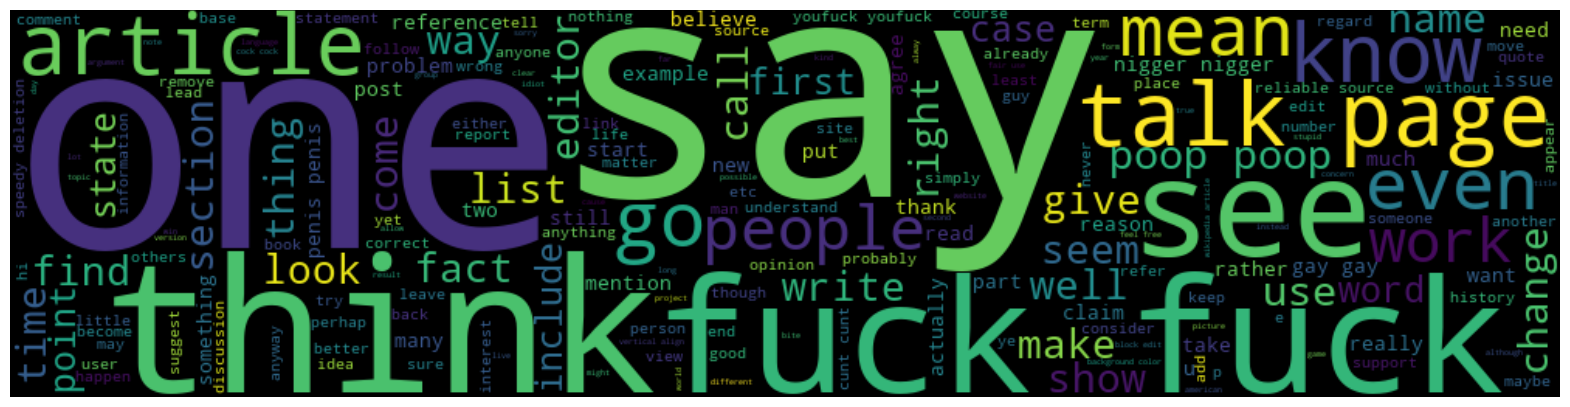

In [33]:
words = ' '.join([k for k in comment_test['Cleaned_data']])
W_C = WordCloud(width=1000, height=250, random_state=31, max_font_size=200).generate(words)

plt.figure(figsize=(20,8))
plt.imshow(W_C, interpolation="bilinear")
plt.axis('off')
plt.show()

# Modeling
I have used 3 models-
1. Logistic Regression - 
2. LinearSVC
3. LSTM

As our dataset is multi-label so I have used OneVsRestClassifier()- as our toxic labels data has 1'0 and 0's as the values. OneVsRestClassifier performs better for this type of datasets as it accepts binary data over multiple labels and results of prediction is also in the form of 0's and 1's.   

# Logistic Regression -Model-1 

### Model-1.1 
#### TF-IDF Vectorizing technique

In [34]:
"""
Here I am passing max-features as 40000 and passing ngram_range (1,2) to create bi-gram models

"""
tf_idf = TfidfVectorizer(analyzer='word', max_features=40000, ngram_range=(1,2), stop_words='english')
X = tf_idf.fit_transform(comment_train['Cleaned_data'])

In [35]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4480696 stored elements and shape (159571, 40000)>

In [36]:
"""
Droping columns id, comment_text, cleaned_data to extract all the labels so that it can be use  in split function

"""
y=comment_train.drop(['id', 'comment_text','Cleaned_data'], axis=1) 
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [37]:
X.shape,y.shape # getting shape of data's

((159571, 40000), (159571, 6))

To split the data I am going to use train_test_split method which is present in sklearn.model_selection package. The train_test_split method is easy to implement and has hyper-parameters like test_size,suffle,random_state ect which will allow me to change the testing data size, suffle the dataset etc.


In [38]:
"""
80%-train
20%-test
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # now splitting the data into train and test so that we can pass fit function for training the data and predict function on test data 

In [39]:

loglr = LogisticRegression(solver='lbfgs')
clf_ovr = OneVsRestClassifier(loglr)

In [40]:
clf_ovr.fit(X_train,y_train)

c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


OneVsRestClassifier(estimator=LogisticRegression())

In [41]:
log_pred= clf_ovr.predict(X_test) # passing the test dataset to predict the toxic labels
log_pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [42]:
c_m=confusion_matrix(y_test.values.argmax(axis=1),log_pred.argmax(axis=1))
c_m

array([[31708,     1,     1,     0,     1],
       [  111,     1,     0,     0,     0],
       [    1,     0,     0,     0,     0],
       [   81,     0,     0,     0,     0],
       [   10,     0,     0,     0,     0]], dtype=int64)

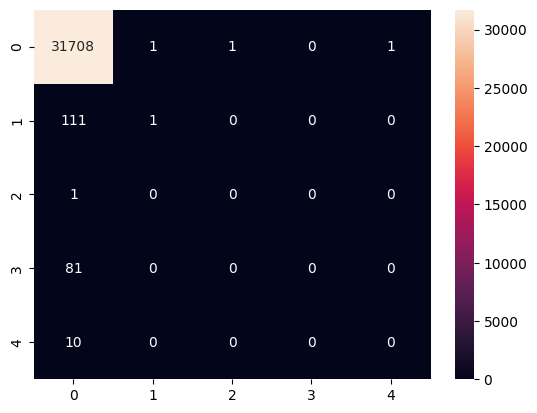

In [43]:
ax = sns.heatmap(c_m, annot=True,fmt="d")

In [44]:
print(classification_report(log_pred.argmax(axis=1),y_test.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     31911
           2       0.01      0.50      0.02         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1

    accuracy                           0.99     31915
   macro avg       0.20      0.30      0.20     31915
weighted avg       1.00      0.99      1.00     31915



c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [45]:
print("f1_score:",f1_score(y_test,log_pred, average="micro"))


f1_score: 0.6763798423037368


## Model-1.2
Changing the parameters like max_features,ngram_range to check how the model is performing

In [46]:
tf_idf = TfidfVectorizer(analyzer='word', max_features=25000, ngram_range=(2,3), stop_words='english') #here i am considering max-features as 25000 and passing tri-gram model 
X = tf_idf.fit_transform(comment_train['Cleaned_data'])

In [47]:
"""
Here I have passed class_weight='balanced' and max_iter=1000 assuming that our model will perform better  as all the labels weight is balanced
"""
loglr = LogisticRegression(solver='lbfgs',class_weight='balanced',max_iter=1000)
clf_ovr = OneVsRestClassifier(loglr)
clf_ovr.fit(X_train,y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000))

In [48]:
log_pred= clf_ovr.predict(X_test)
log_pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [49]:
c_m=confusion_matrix(y_test.values.argmax(axis=1),log_pred.argmax(axis=1))
c_m

array([[31533,     3,    19,    35,    34,    87],
       [    0,     0,     0,     0,     0,     0],
       [  109,     0,     3,     0,     0,     0],
       [    1,     0,     0,     0,     0,     0],
       [   80,     0,     0,     0,     1,     0],
       [    9,     0,     0,     0,     0,     1]], dtype=int64)

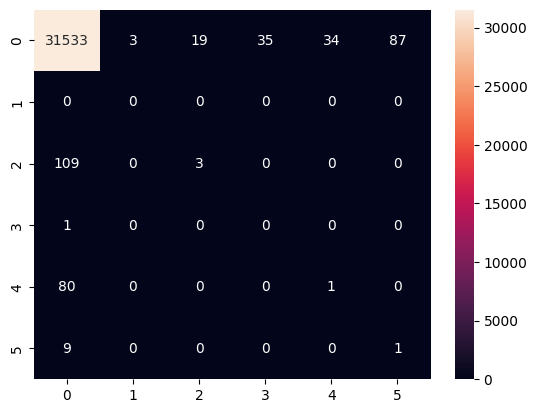

In [50]:
ax = sns.heatmap(c_m, annot=True,fmt="d")

In [51]:
print(classification_report(log_pred.argmax(axis=1),y_test.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31732
           1       0.00      0.00      0.00         3
           2       0.03      0.14      0.04        22
           3       0.00      0.00      0.00        35
           4       0.01      0.03      0.02        35
           5       0.10      0.01      0.02        88

    accuracy                           0.99     31915
   macro avg       0.19      0.20      0.18     31915
weighted avg       0.99      0.99      0.99     31915



c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [52]:
print("f1_score:",f1_score(y_test,log_pred, average="micro"))

f1_score: 0.6765656676346502


 ## Model-1.3
now performing logistic regression using Countvectorizer

In [53]:
X_train, X_test, y_train, y_test = train_test_split(comment_train['Cleaned_data'], y, test_size = .20)

In [54]:
cv = CountVectorizer(max_features=20000,max_df=0.8,min_df=0.001,ngram_range=(1,2)) # setting up CountVectorizer values and by default it is creating bi-gram model

In [55]:
x_features = cv.fit_transform(X_train)
x_features

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3120406 stored elements and shape (127656, 4323)>

In [56]:
x_test_features = cv.transform(X_test)

In [57]:
log = LogisticRegression()
clf = OneVsRestClassifier(log)

In [58]:
clf.fit(x_features,y_train)

c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

OneVsRestClassifier(estimator=LogisticRegression())

In [59]:
log_pred= clf.predict(x_test_features)

In [60]:
log_pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [61]:
cm=confusion_matrix(y_test.values.argmax(axis=1),log_pred.argmax(axis=1))
cm

array([[31674,     1,    18,    10,    12,    21],
       [    0,     0,     0,     0,     0,     0],
       [  106,     0,     2,     0,     0,     0],
       [    4,     0,     0,     0,     0,     0],
       [   59,     0,     0,     0,     0,     0],
       [    8,     0,     0,     0,     0,     0]], dtype=int64)

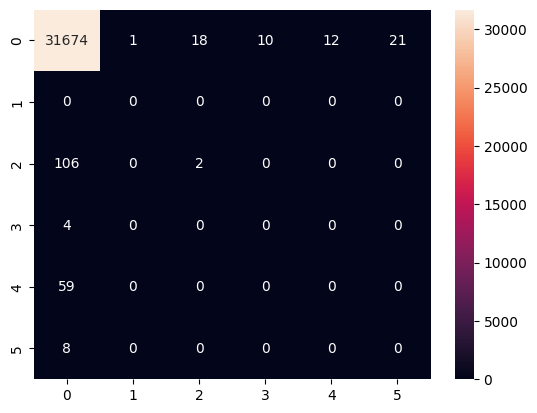

In [62]:
ax = sns.heatmap(cm, annot=True,fmt="d")

In [63]:
print(classification_report(log_pred.argmax(axis=1),y_test.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     31851
           1       0.00      0.00      0.00         1
           2       0.02      0.10      0.03        20
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00        21

    accuracy                           0.99     31915
   macro avg       0.17      0.18      0.17     31915
weighted avg       1.00      0.99      0.99     31915



c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sksad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [64]:
print("f1_score:",f1_score(y_test,log_pred, average="micro"))

f1_score: 0.647410358565737


here we can see that our model is overfitting due to imbalanced dataset and it is giving 0.99 accuracy in both TFIDF and countvectorizer vectorizing techniques even though we have also changed the hyperparameters like n_gram,max_features but the accuracy remains the same.

## Model-1.4
#### Now Let's remove the the column "Toxic" and see how our model is preforming in both the above vectorizing technique

I am removing this column as our model is giving more preference to this columns and removing this column might help us to get better results

In [65]:
# Here I have used tf_idf beacause our model performs in a same way  in both the vectorizing technique. And using TF_IDF gave me f1-score of 0.66 however countvectorizer gave me fi-score of 0.64
tf_idf = TfidfVectorizer(analyzer='word', max_features=40000, ngram_range=(1,2), stop_words='english') #here i am considering max-features as 40000 and passing bi-gram model 
X = tf_idf.fit_transform(comment_train['Cleaned_data'])
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4480696 stored elements and shape (159571, 40000)>

In [66]:


# Get feature names
name_of_features = tf_idf.get_feature_names_out()

# Print the first 50 feature names (if there are that many)
print(name_of_features[0:50])


['aa' 'aap' 'aardvark' 'aaron' 'ab' 'aba' 'abandon' 'abandonment' 'abbas'
 'abbey' 'abbott' 'abbreviate' 'abbreviation' 'abbreviations' 'abc'
 'abc news' 'abd' 'abduct' 'abduction' 'abdul' 'abdullah' 'abe' 'abhira'
 'abhiras' 'abhishek' 'abhorrent' 'abide' 'abide wikipedia' 'abilities'
 'ability' 'ability create' 'ability edit' 'ability rename' 'abit'
 'abkhazia' 'able' 'able add' 'able block' 'able change' 'able check'
 'able come' 'able contribute' 'able edit' 'able help' 'able look'
 'able make' 'able post' 'able provide' 'able read' 'able stand']


In [67]:
y=comment_train.drop(['id', 'comment_text','Cleaned_data'], axis=1)
y.drop(['toxic'], axis=1, inplace=True)
y

,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
159566,0,0,0,0,0
159567,0,0,0,0,0
159568,0,0,0,0,0
159569,0,0,0,0,0


In [68]:
"""
train-75%
test-25%
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

In [69]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1,max_iter=1000) #creating object and passing hyperparameters for logistic model
clf = OneVsRestClassifier(lr)

In [70]:
clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1))

In [71]:
log_pred= clf.predict(X_test)
log_pred

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [72]:
cm=confusion_matrix(y_test.values.argmax(axis=1),log_pred.argmax(axis=1))
cm

array([[37186,   339,     1,    45,     4],
       [  782,   944,     1,    56,     1],
       [   38,     1,     3,     1,     0],
       [  368,    19,     0,    50,     1],
       [   46,     1,     0,     4,     2]], dtype=int64)

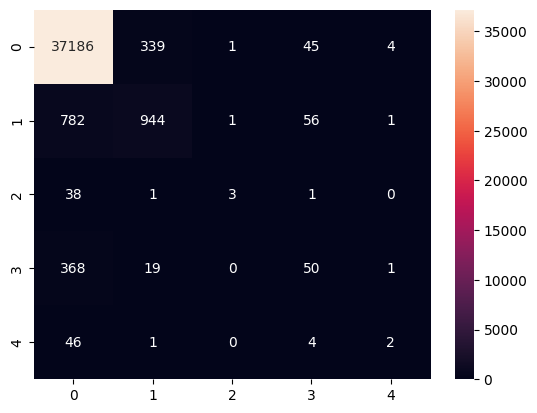

In [73]:
ax = sns.heatmap(cm, annot=True,fmt="d")

In [74]:
print(classification_report(log_pred.argmax(axis=1),y_test.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     38420
           1       0.53      0.72      0.61      1304
           2       0.07      0.60      0.12         5
           3       0.11      0.32      0.17       156
           4       0.04      0.25      0.07         8

    accuracy                           0.96     39893
   macro avg       0.35      0.57      0.39     39893
weighted avg       0.97      0.96      0.96     39893



In [75]:
accuracy_log_pred=accuracy_score(y_test.values.argmax(axis=1),log_pred.argmax(axis=1))
accuracy_log_pred

0.9571854711352868

In [76]:
print("f1_score:",f1_score(y_test,log_pred, average="micro"))

f1_score: 0.6264245460237946


After balancing the dataset by droping the toxic column we are getting 0.95 accuracy. As previously because of overfitting we were getting 0.99 accuracy.

# model-2 LinearSVC 

In [77]:
svc = LinearSVC() #creating object for linear SVC

In [78]:
clf = OneVsRestClassifier(svc) 

In [79]:
clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=LinearSVC())

In [80]:
svc_pred= clf.predict(X_test)
svc_pred

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [81]:
cm_svc=confusion_matrix(y_test.values.argmax(axis=1),svc_pred.argmax(axis=1))
cm_svc

array([[37045,   419,     3,    86,    22],
       [  641,  1050,     3,    86,     4],
       [   35,     2,     5,     1,     0],
       [  319,    38,     2,    76,     3],
       [   41,     1,     0,     6,     5]], dtype=int64)

In [82]:
print(classification_report(svc_pred.argmax(axis=1),y_test.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     38081
           1       0.59      0.70      0.64      1510
           2       0.12      0.38      0.18        13
           3       0.17      0.30      0.22       255
           4       0.09      0.15      0.11        34

    accuracy                           0.96     39893
   macro avg       0.39      0.50      0.43     39893
weighted avg       0.96      0.96      0.96     39893



In [83]:
accuracy_svc_pred=accuracy_score(y_test.values.argmax(axis=1),svc_pred.argmax(axis=1))
accuracy_svc_pred

0.9570852029178051

In [84]:
print("f1_score:",f1_score(y_test,svc_pred, average="micro"))

f1_score: 0.6658195679796696


#### Comparing both the model logistic and linearSVC
So, if we compare both the model logistic and linearSVC we can say that both the models are performing very good as the accuracy obtain from both model on testing dataset is approxmately same but the fi-score of linearsvc is better than logistic.

# Model-3 LSTM


In [85]:
data_tr = comment_train["Cleaned_data"]
data_ts = comment_test["Cleaned_data"]
train_categories=comment_train[cols]

In [86]:
train_categories
#train_categories.drop(['toxic'], axis=1, inplace=True)
train_categories

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [87]:
tokken=Tokenizer(num_words = 20000) 

In [88]:
tr_final = tokken.texts_to_sequences(data_tr)
ts_final = tokken.texts_to_sequences(data_ts)

In [89]:
max_len=150

tr_padded =pad_sequences(tr_final, maxlen=max_len)
ts_padded =pad_sequences(ts_final, maxlen=max_len)
print(tr_padded.shape)
print(ts_padded.shape)

(159571, 150)
(153164, 150)


In [90]:
model = Sequential()
model.add(Embedding(20000, 64))
model.add(LSTM(units = 32, dropout = 0.1,return_sequences=True))
model.add(LSTM(units = 32, dropout = 0.1))
model.add(Dense(units = 6, activation = 'relu'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 lstm (LSTM)                 (None, None, 32)          12416     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 1300934 (4.96 MB)
Trainable params: 1300934 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
# here I have passed categorical_crossentropy as the loss function and optimizer as 'adam'.

In [92]:
#optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics = ["accuracy"])
x_train, x_test, y_train, y_test = train_test_split(tr_padded, train_categories, shuffle = True)
model3_LSTM=model.fit(x_train, y_train, batch_size = 100, epochs = 2, validation_data = (x_test, y_test))


Epoch 1/2


1197/1197 [==============================] - 323s 266ms/step - loss: 0.4322 - accuracy: 0.9849 - val_loss: 0.4228 - val_accuracy: 0.9943
Epoch 2/2
1197/1197 [==============================] - 318s 266ms/step - loss: 0.4542 - accuracy: 0.9941 - val_loss: 0.4537 - val_accuracy: 0.9943


Using categorical_crossentropy as the loss function our model is overfitting as the categorical_crossentropy assumes the sum of probability of all the classes is 1. This happens in the case of multiclass where 1 sample as 1 class. But our model is multilabel that may be the reason our model is overfitting.

In [93]:
pred = model.predict(ts_padded) #testing the model on testing dataset

4787/4787 [==============================] - 143s 29ms/step


In [94]:
pred

array([[2.1553493 , 0.        , 1.2496897 , 0.        , 1.1238397 ,
        0.24575403],
       [2.1553493 , 0.        , 1.2496897 , 0.        , 1.1238397 ,
        0.24575403],
       [2.1553493 , 0.        , 1.2496897 , 0.        , 1.1238397 ,
        0.24575403],
       ...,
       [2.1553493 , 0.        , 1.2496897 , 0.        , 1.1238397 ,
        0.24575403],
       [2.1553493 , 0.        , 1.2496897 , 0.        , 1.1238397 ,
        0.24575403],
       [2.1553493 , 0.        , 1.2496897 , 0.        , 1.1238397 ,
        0.24575403]], dtype=float32)

In [95]:
target_cols = np.array(cols)
final_predict_test = pd.concat([pd.DataFrame(pred, columns=target_cols)], axis=1)  # Use axis=1 instead of 1
test_id = comment_test['id']
Comment = comment_test.Cleaned_data
final_predict_test = pd.concat([test_id, Comment, final_predict_test], axis=1)  # Use axis=1 instead of 1


In [96]:
# Changing Hyperparameter to see if the model perfroms better

In [97]:
"""
here we have created an object for sequential model as we need to pass our data in a sequential format

"""
model = Sequential() 
model.add(Embedding(40000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid')) #here I have changed the activation layer from softmax to sigmoidal
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         5120000   
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 5202822 (19.85 MB)
Trainable params: 5202822 (19.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_test, y_train, y_test = train_test_split(tr_padded, train_categories, shuffle = True, random_state = 123)
model3_lstm2=model.fit(x_train, y_train, batch_size = 32, epochs = 4, validation_data = (x_test, y_test))

Epoch 1/4


Binary_crossentropy is giving less accuracy as compared to categorical_crossentropy but binary_crossentropy optimises each a class independently which will more useful in multilabel's dataset as one input can take more than two output labels. 

In [101]:
print(model3_lstm2.history.keys())
plt.plot(model3_lstm2.history['auc'])
plt.plot(model3_lstm2.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_dataset', 'test_dataset'])
plt.show()

NameError: name 'model3_lstm2' is not defined

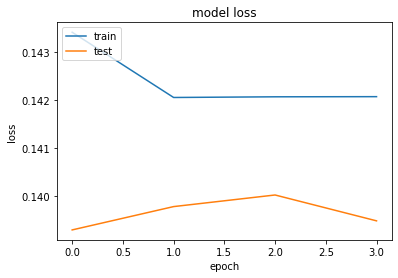

In [105]:
plt.plot(model3_lstm2.history['loss'])
plt.plot(model3_lstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Now performing hyperparameter tuning:

In [106]:
tokken=Tokenizer(num_words = 40000)  #increased the number of words
tokken.fit_on_texts(data_tr)
tr_final = tokken.texts_to_sequences(data_tr)
ts_final = tokken.texts_to_sequences(data_ts)

In [107]:
#sequece padding
tr_padded =pad_sequences(tr_final, maxlen=150)
ts_padded =pad_sequences(ts_final, maxlen=150)
print(tr_padded.shape)
print(ts_padded.shape)

(159571, 150)
(153164, 150)


In [108]:
"""
here we have created an object for sequential model as we need to pass our data in a sequential format

"""
model = Sequential() 
model.add(Embedding(40000, 128))
model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation = 'sigmoid')) #here I have changed the activation layer from softmax to sigmoidal
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 5,202,822
Trainable params: 5,202,822
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
x_train, x_test, y_train, y_test = train_test_split(tr_padded, train_categories, shuffle = True, random_state = 123)
model3_lstm3=model.fit(x_train, y_train, batch_size = 32, epochs = 3, validation_data = (x_test, y_test))

Epoch 1/3
3740/3740 [==============================] - 752s 199ms/step - loss: 0.1016 - auc: 0.8983 - val_loss: 0.0489 - val_auc: 0.9818
Epoch 2/3
3740/3740 [==============================] - 729s 195ms/step - loss: 0.0464 - auc: 0.9836 - val_loss: 0.0470 - val_auc: 0.9793
Epoch 3/3
3740/3740 [==============================] - 744s 199ms/step - loss: 0.0415 - auc: 0.9869 - val_loss: 0.0475 - val_auc: 0.9773


After hyperparameter tuning our model is giving accuracy of .97 which is highest among all the single dense layer LSTM I have implemented above

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


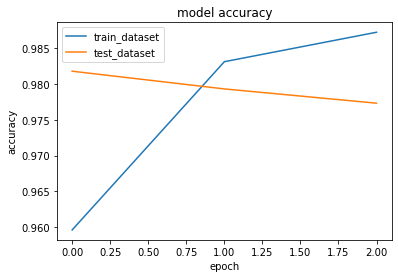

In [110]:
print(model3_lstm3.history.keys())
plt.plot(model3_lstm3.history['auc'])
plt.plot(model3_lstm3.history['val_auc'])
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('model accuracy')
plt.legend(['train_dataset', 'test_dataset'])
plt.show()

In [111]:
print(model3_lstm3.history['val_auc'])

[0.9817785024642944, 0.9793030619621277, 0.9773085713386536]


In [115]:
lstm_accuracy=model3_lstm3.history['val_auc'][2:]
lstm_accuracy[0]

0.9773085713386536

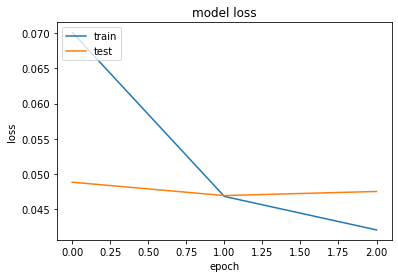

In [204]:
plt.plot(model3_lstm3.history['loss'])
plt.plot(model3_lstm3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [205]:
pred = model.predict(ts_padded) #testing the model on testing dataset
pred

array([[9.9335337e-01, 3.4740573e-01, 9.5265293e-01, 1.7506972e-01,
        8.6911500e-01, 2.7152634e-01],
       [5.6755543e-04, 2.2274201e-06, 1.4927983e-04, 8.3778323e-06,
        1.0068659e-04, 1.7783786e-05],
       [1.0799587e-02, 6.7491303e-05, 1.9396544e-03, 2.6091933e-04,
        2.4507940e-03, 4.1383505e-04],
       ...,
       [5.0616264e-04, 1.6260913e-06, 1.4331937e-04, 6.2802142e-06,
        8.1687540e-05, 1.3838857e-05],
       [5.1361322e-04, 1.7194417e-06, 1.3533235e-04, 7.0869673e-06,
        8.0342441e-05, 1.5160098e-05],
       [9.7921187e-01, 4.0902972e-02, 8.8346732e-01, 1.2213409e-02,
        6.7306024e-01, 5.1521271e-02]], dtype=float32)

In [206]:
target_cols = np.array(cols)
final_predict_test = pd.concat([pd.DataFrame(pred, columns=target_cols)], 1)
test_id = comment_test['id']
Comment=comment_test.Cleaned_data
final_predict_test = pd.concat([test_id,Comment,final_predict_test],1)
final_predict_test

,id,Cleaned_data,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hat sad ...,0.993353,0.347406,0.952653,0.175070,0.869115,0.271526
1,0000247867823ef7,rfc title fine imo,0.000568,0.000002,0.000149,0.000008,0.000101,0.000018
2,00013b17ad220c46,source zawe ashton lapland,0.010800,0.000067,0.001940,0.000261,0.002451,0.000414
3,00017563c3f7919a,look back source information update correct fo...,0.000575,0.000002,0.000154,0.000008,0.000094,0.000016
4,00017695ad8997eb,anonymously edit article,0.001106,0.000005,0.000266,0.000019,0.000217,0.000034
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,totally agree stuff nothing long crap,0.701124,0.002144,0.193172,0.001270,0.238277,0.014275
153160,fffd7a9a6eb32c16,throw field home plate get faster throw cut ma...,0.003133,0.000008,0.000497,0.000029,0.000549,0.000075
153161,fffda9e8d6fafa9e,okinotorishima categories see change agree cor...,0.000506,0.000002,0.000143,0.000006,0.000082,0.000014
153162,fffe8f1340a79fc2,one found nations eu germany law return quite ...,0.000514,0.000002,0.000135,0.000007,0.000080,0.000015


# Accuracies

Here I have compared all the 3 model's performance.

<ipython-input-116-006e2347380b>:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(lab,val,color='rgb')


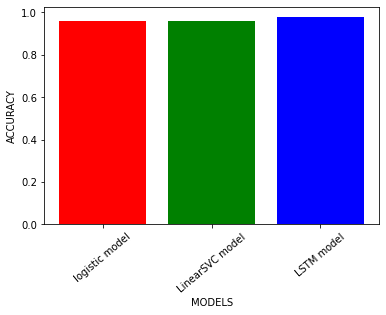

In [116]:
# write about each model
lab=['logistic model','LinearSVC model','LSTM model'] #empty list to store the labels of dataset
val=[accuracy_log_pred,accuracy_svc_pred,lstm_accuracy[0]] #empty list to store the count of the values
plt.bar(lab,val,color='rgb')
plt.xticks(rotation=40)
plt.xlabel("MODELS")
plt.ylabel("ACCURACY")
plt.show()

The graph depicts that our model has performed better with lstm approach with the accuracy of .97 as compared to logistic and linear svc where the accuracy is .957,.958 respectively.

# Creating a testing model to test my model with external data

In [117]:
com = ['i will kill you','dumb ass', 'piece of shit', "yor are an idiot", "you are an asshole","Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time"]

In [118]:
xt = tf_idf.transform(com)

In [119]:
category=clf.predict(xt)
category

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0]])

In [120]:
col=[ 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
cat = pd.DataFrame(category,columns=col)
cat

,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,1,0,0
1,0,1,0,1,0
2,0,1,0,1,0
3,0,0,0,1,0
4,0,1,0,1,0
5,0,1,0,1,0


In [122]:
for i in range(len(cat)):
    if cat.columns[(cat == 1).iloc[i]].notna().all():
        print(cat.columns[(cat == 1).iloc[i]].values)

['threat']
['obscene' 'insult']
['obscene' 'insult']
['insult']
['obscene' 'insult']
['obscene' 'insult']
